#### 【 안정화 Layer - BachNormLayer 】 <hr>

- 문제 상황
    * 신경망에서 한 층의 출력 분포가 계속 변함.
    * 가중치 업데이트 → 다음 층 입력 분포 변화 → 학습 불안정, 느린 수렴
    * Internal Covariate Shift 설명함

- 해결 방안
    * 미니배치 단위로 평균과 분산 맞추어 각 층의 입력 분포를 안정화
    * 평균 0, 분산 1 데이터 위치 변경 ==> 선형 변환(affine transform) 
        - 값들의 순서 유지
        - 상대적 거리 비율 유지
        - 정보 보존
- 효과
    * 기울기가 안정적으로 흐름
    * 활성함수가 가장 잘 작동
    * 학습이 빠르고 안정적
        
- 순서
    1. 미니배치 평균
    2. 미니배치 분산
    3. 정규화
    4. 학습 가능한 복원 => 정규화 후에도 표현력 유지 위함
        - γ (gamma) : scale - 얼마나 강조할지
        - β (beta) : shift - 어디로 이동시킬지

In [2]:
##- 모듈 로딩
import torch 
import torch.nn as nn

In [21]:
## ---------------------------------------------------
## BatchNorm 없이
## ---------------------------------------------------
x = torch.randn(4, 3) * 10 + 50  
print(x)


KeyboardInterrupt: 

In [ ]:
##- eps : 입실론(epsilon, ε)
##-       분산이 0에 가까울 때
##-       나눗셈이 폭주하거나 NaN이 되는 것을 막기 위한
##-       아주 작은 안정화 상수
eps = 1e-5

# 1) batch 통계
mean = x.mean(dim=0)
var  = x.var(dim=0, unbiased=False)

# 2) 정규화
x_hat = (x - mean) / torch.sqrt(var + eps)

# 3) 학습 파라미터
gamma = torch.ones(3)
beta  = torch.zeros(3)

y = gamma * x_hat + beta

# 4) 변화된 평균/분산
print("입력 평균:", x.mean(dim=0))
print("입력 분산:", x.var(dim=0, unbiased=False))
print("-"*60)
print("출력 평균:", y.mean(dim=0))
print("출력 분산:", y.var(dim=0, unbiased=False))

입력 평균: tensor([53.8035, 57.0806, 46.5486])
입력 분산: tensor([104.2052,  27.7606,  11.3118])
------------------------------------------------------------
출력 평균: tensor([-1.7881e-07, -3.4273e-07,  2.9802e-07])
출력 분산: tensor([1.0000, 1.0000, 1.0000])


In [ ]:
## ---------------------------------------------------
## BatchNorm1d 사용
## ---------------------------------------------------
##- 인스턴스 생성
bn = nn.BatchNorm1d(3)

##- 훈련 모드 
bn.train()   

##- 
y = bn(x)

print("출력 평균:", y.mean(dim=0))
print("출력 분산:", y.var(dim=0, unbiased=False))

## 내부에서 똑같은 계산 + γ, β 학습을 자동으로 수행

출력 평균: tensor([ 0.0000e+00,  7.1526e-07, -2.3842e-07], grad_fn=<MeanBackward1>)
출력 분산: tensor([1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>)


In [12]:
## ------------------------------------------------
##          학습(train) vs 평가(eval) 차이 
## -------------------------------------------------
## [학습 시 ]
## -> 현재 미니배치 평균/분산 사용
## -> 동시에 running_mean, running_var 갱신

## [평가 시 ]
## -> running_mean, running_var만 사용
## -> 배치 크기에 영향 없음

bn.eval()    
y_test = bn(x)


In [15]:
##%pip install koreanize-matplotlib

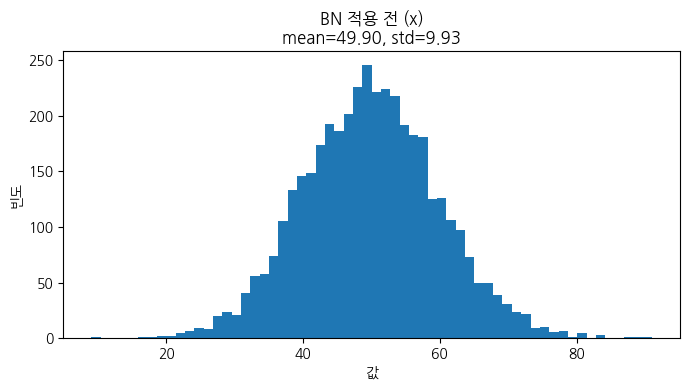

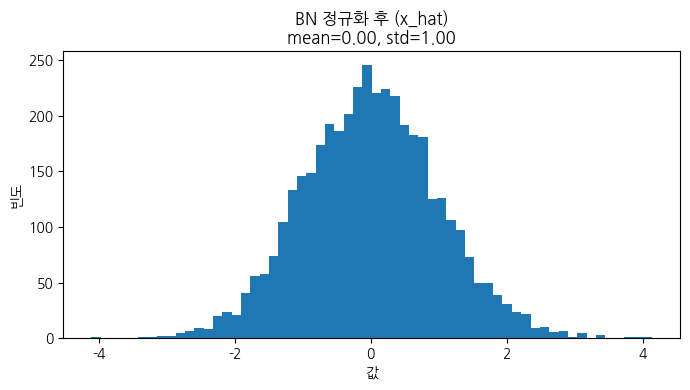

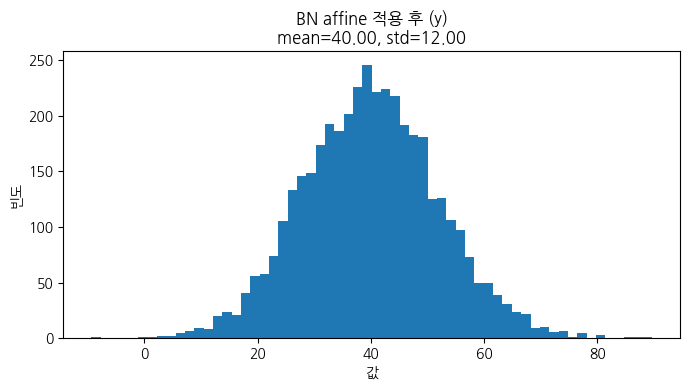

분포 요약
BN 적용 전           : mean=49.9037, var=98.6565
BN 정규화 후 (x_hat) : mean=0.0000, var=1.0000
BN affine 후 (y)     : mean=40.0000, var=144.0000


In [ ]:
## -----------------------------
## 모듈 로딩
## -----------------------------
import torch
import matplotlib.pyplot as plt
import koreanize_matplotlib

## -----------------------------
## 재현성을 위한 시드 고정
## -----------------------------
torch.manual_seed(0)

## -----------------------------
## 1) BN 적용 전 입력 데이터 생성
##    평균이 크고 분산이 큰 
##    불안정한 분포를 일부러 만듦
## -----------------------------
N = 4096
x = torch.randn(N) * 10 + 50   # 평균≈50, 표준편차≈10

## -----------------------------
## 2) BatchNorm의 정규화 단계
##    (미니배치 평균, 분산 사용)
## -----------------------------
eps  = 1e-5                   # 수치 안정성을 위한 epsilon
mean = x.mean()               # 배치 평균
var  = x.var(unbiased=False)  # 배치 분산

# 평균 0, 분산 1로 정규화
x_hat = (x - mean) / torch.sqrt(var + eps)

## -----------------------------
## 3) BatchNorm의 affine 변환 (γ, β)
##    → 필요하면 분포를 다시 이동/확대
## -----------------------------
gamma = torch.tensor(12.0)    # 스케일 파라미터 (학습 대상)
beta  = torch.tensor(40.0)    # 시프트 파라미터 (학습 대상)

y = gamma * x_hat + beta

## -----------------------------
## 통계 출력용 함수
## -----------------------------
def stats(t):
    return float(t.mean()), float(t.std(unbiased=False)), float(t.var(unbiased=False))

mx, sx, vx = stats(x)
mh, sh, vh = stats(x_hat)
my, sy, vy = stats(y)

## -----------------------------
## 4) BN 적용 전 분포 시각화
## -----------------------------
plt.figure(figsize=(7,4))
plt.hist(x.numpy(), bins=60)
plt.title(f"BN 적용 전 (x)\nmean={mx:.2f}, std={sx:.2f}")
plt.xlabel("값")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

## -----------------------------
## 5) BN 정규화 후 분포 시각화
## -----------------------------
plt.figure(figsize=(7,4))
plt.hist(x_hat.numpy(), bins=60)
plt.title(f"BN 정규화 후 (x_hat)\nmean={mh:.2f}, std={sh:.2f}")
plt.xlabel("값")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

## -----------------------------
## 6) γ, β 적용 후 분포 시각화
## -----------------------------
plt.figure(figsize=(7,4))
plt.hist(y.numpy(), bins=60)
plt.title(f"BN affine 적용 후 (y)\nmean={my:.2f}, std={sy:.2f}")
plt.xlabel("값")
plt.ylabel("빈도")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) 요약 통계 출력
# -----------------------------
print("분포 요약")
print(f"BN 적용 전           : mean={mx:.4f}, var={vx:.4f}")
print(f"BN 정규화 후 (x_hat) : mean={mh:.4f}, var={vh:.4f}")
print(f"BN affine 후 (y)     : mean={my:.4f}, var={vy:.4f}")
